In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import glob

PRESSURE_VARIABLES=[
    "geopotential",
    "u_component_of_wind",
    "v_component_of_wind",
    "specific_humidity",
    "temperature",
    "vertical_velocity"
]

SURFACE_VARIABLES=[
    "10m_u_component_of_wind", 
    "10m_v_component_of_wind", 
    "total_precipitation_6hr", 
    "mean_sea_level_pressure"
]

files_t2m = sorted(glob.glob('/geodata2/S2S/ECMWF_Perturbed/Dailyaveraged/t2m/nc/*/Temperature2m_2021-06-21.nc'))
files_t2m = [f for f in files_t2m if int(f.split('/')[-2]) <= 24 * 10]

partition_1 = sorted(glob.glob('/data/GC_output/2021-06-21/GC_???????????_global_*.nc'))
partition_2 = sorted(glob.glob('/data/GC_output/2021-06-21/GC_00100000000_*_*.nc'))
partition_3 = sorted(glob.glob('/data/GC_output/2021-06-21/GC_11011111111_*_*.nc'))

# files_slp = sorted(glob.glob('/geodata2/S2S/ECMWF_Perturbed/InstantaneousAccumulated/mslp/nc/*/MeanSeaLevelPressure_2021-06-21.nc'))
# files_slp = [f for f in files_t2m if int(f.split('/')[-2]) <= 24 * 10]

In [ ]:
def weighted_mean(dataset:xr.Dataset):
    # for GC_* files
    if "level" in dataset.dims:
        dataset = dataset.resample(time="1D").mean().squeeze('batch')
        dataset = dataset.drop_vars(PRESSURE_VARIABLES + SURFACE_VARIABLES + ['level'])
        dataset["time"] = pd.date_range("2021-06-22", periods=10, freq="1D")
        dataset = dataset.rename({"time":"date"})
        # dataset = dataset.sel(lat=slice(25, 60), lon=slice(102.5, 150))

    # for nwp files
    elif "time" in dataset.dims:
        dataset = dataset.expand_dims(dim={'date': [dataset.time.values[0]]}).compute()
        dataset = dataset.rename({'time': 'ensemble'})
        dataset['ensemble'] = np.arange(1, 51)
        dataset.drop_dims('height')
        # dataset = dataset.sel(lat=slice(60, 24), lon=slice(102, 150))

    # for era5 files
    # else:
        # dataset = dataset.sel(lat=slice(60, 25), lon=slice(102.5, 150))

    
    weights = np.cos(np.deg2rad(dataset.lat))
    weights.name = "weights"
    weighted = dataset.weighted(weights)
    
    return weighted.mean(('lat', 'lon'))

# nwp = xr.open_mfdataset(files_t2m, combine='by_coords', preprocess=weighted_mean).squeeze('height').drop_vars('height')
# nwp = nwp.rename({"2t":"2m_temperature"}).compute()

perturb_files = [
    "testdata/2021-06-21/GC_4var_1std.nc",
    "testdata/2021-06-21/GC_4var_0.1std.nc",
    "testdata/2021-06-21/GC_4var_3std.nc",
    "testdata/2021-06-21/GC_4var_0.001std.nc",
    "testdata/2021-06-21/GC_4var_5std.nc"
]

perturb_datasets = [weighted_mean(xr.open_dataset(file)) for file in perturb_files]

# era5 = xr.open_dataset("/camdata2/ERA5/daily/t2m/2021.nc").rename({"time":"date", "latitude":"lat", "longitude":"lon"}).sel(date=slice("2021-06-22", "2021-07-01"))

# era5 = weighted_mean(era5)

In [3]:
# file naming convention
# GC_{11 digit binary}_{region name}_{perturbatinon way}_{perturbation value}.nc
# e.g.
# GC_00000000001_Southern Hemisphere Extra-tropics_scale_0.001.nc
# GC_00000000001_Southern Hemisphere Extra-tropics_scale_1.nc
# GC_00000000001_Southern Hemisphere Extra-tropics_wipeout_-3.4028234663852886e+38.nc
# GC_00000000001_Southern Hemisphere Extra-tropics_wipeout_3.4028234663852886e+38.nc



In [9]:
import re

# Function to extract scale value from filename
def extract_scale_value(filename):
    match = re.search(r'_scale_([\d.eE+-]+)\.nc$', filename)
    if match:
        return match.group(1)
    else:
        return None

# Function to extract wipeout value from filename
def extract_wipeout_value(filename):
    match = re.search(r'_wipeout_([\d.eE+-]+)\.nc$', filename)
    if match:
        return match.group(1)
    else:
        return None

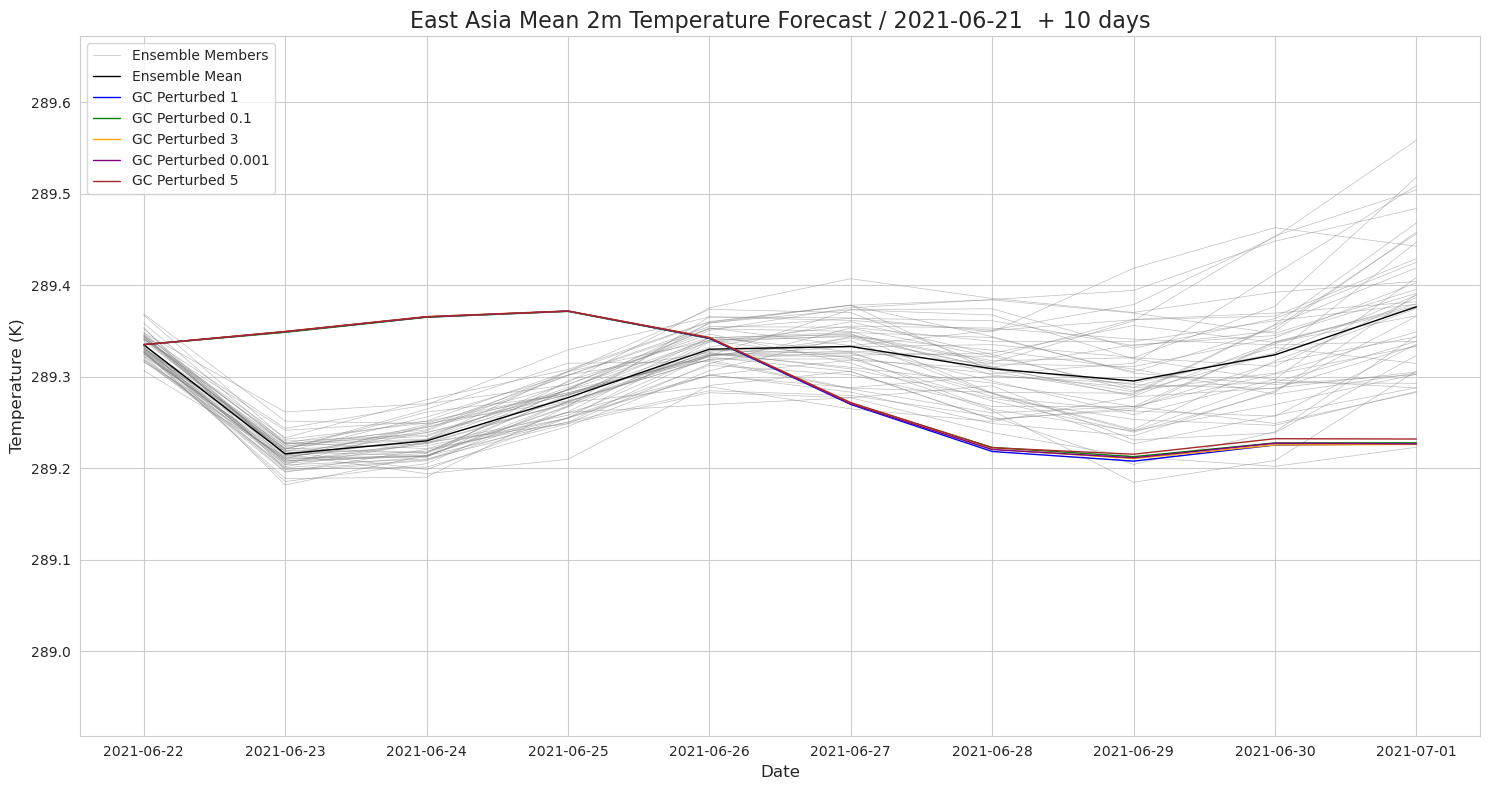

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib Figure 설정
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

nwp = xr.open_mfdataset(files_t2m, combine='by_coords', preprocess=weighted_mean).squeeze('height').drop_vars('height')
nwp = nwp.rename({"2t":"2m_temperature"}).compute()
df = nwp['2m_temperature'].to_dataframe().reset_index()


first_ensemble = True
for ensemble in df['ensemble'].unique():
    subset = df[df['ensemble'] == ensemble]
    if first_ensemble:
        plt.plot(subset['date'], subset['2m_temperature'], color='grey', linewidth=0.5, alpha=0.5, label='Ensemble Members')
        first_ensemble = False
    else:
        plt.plot(subset['date'], subset['2m_temperature'], color='grey', linewidth=0.5, alpha=0.5)


mean_temp = df.groupby('date')['2m_temperature'].mean().reset_index()
plt.plot(mean_temp['date'], mean_temp['2m_temperature'], color='black', linewidth=1, label='Ensemble Mean')


perturb_files = [
    ("GC Perturbed 1", "blue", perturb_datasets[0]),
    ("GC Perturbed 0.1", "green", perturb_datasets[1]),
    ("GC Perturbed 3", "orange", perturb_datasets[2]),
    ("GC Perturbed 0.001", "purple", perturb_datasets[3]),
    ("GC Perturbed 5", "brown", perturb_datasets[4])
]

for label, color, dataset in perturb_files:
    plt.plot(dataset['date'], dataset['2m_temperature'], color=color, linewidth=1, label=label)

# plt.plot(era5['date'], era5['t2m'], color='red', linewidth=1.5, linestyle='dashed', label='ERA5')

plt.title('East Asia Mean 2m Temperature Forecast / 2021-06-21  + 10 days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.legend(fontsize=10)

y_min = min([dataset['2m_temperature'].min() for _, _, dataset in perturb_files]) - 0.3
y_max = max([dataset['2m_temperature'].max() for _, _, dataset in perturb_files]) + 0.3
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()
# plt.savefig('figure/2m_temperature_forecast_east asia mean_0.001to5_2021-06-21.png')


In [15]:
def weighted_mean(dataset:xr.Dataset):
    # for GC_* files
    if "level" in dataset.dims:
        dataset = dataset.resample(time="1D").mean().squeeze('batch')
        dataset = dataset.drop_vars(PRESSURE_VARIABLES + SURFACE_VARIABLES + ['level'])
        dataset["time"] = pd.date_range("2021-06-22", periods=7, freq="1D")
        dataset = dataset.rename({"time":"date"})
        # dataset = dataset.sel(lat=slice(25, 60), lon=slice(102.5, 150))

    # for nwp files
    elif "time" in dataset.dims:
        dataset = dataset.expand_dims(dim={'date': [dataset.time.values[0]]}).compute()
        dataset = dataset.rename({'time': 'ensemble'})
        dataset['ensemble'] = np.arange(1, 51)
        dataset.drop_dims('height')

# Collect perturbation files with labels and colors
perturb_files = []
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink', 'red', 'cyan']
color_idx = 0

for partition in [partition_1, partition_2, partition_3]:
    for file in partition:
        if 'scale' in file:
            scale_value = extract_scale_value(file)
            if scale_value:
                label = f"Scale {scale_value} ({file.split('_')[1]})"
                color = colors[color_idx % len(colors)]
                color_idx += 1
                perturb_files.append((label, color, file))
        elif 'wipeout' in file:
            wipeout_value = extract_wipeout_value(file)
            if wipeout_value:
                label = f"Wipeout {wipeout_value} ({file.split('_')[1]})"
                color = colors[color_idx % len(colors)]
                color_idx += 1
                perturb_files.append((label, color, file))

# Preprocess the perturbation datasets
perturb_datasets = []
for label, color, file in perturb_files:
    dataset = weighted_mean(xr.open_dataset(file))
    perturb_datasets.append((label, color, dataset))

# Now proceed with your plotting code
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib Figure 설정
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

files_t2m = sorted(glob.glob('/geodata2/S2S/ECMWF_Perturbed/Dailyaveraged/t2m/nc/*/Temperature2m_2021-06-21.nc'))
files_t2m = [f for f in files_t2m if int(f.split('/')[-2]) <= 24 * 7]
# Process the NWP data
nwp = xr.open_mfdataset(files_t2m, combine='by_coords', preprocess=weighted_mean)
nwp = nwp.rename({"2t":"2m_temperature"}).compute()
df = nwp['2m_temperature'].to_dataframe().reset_index()

# Plot ensemble members
first_ensemble = True
for ensemble in df['ensemble'].unique():
    subset = df[df['ensemble'] == ensemble]
    if first_ensemble:
        plt.plot(subset['date'], subset['2m_temperature'], color='grey', linewidth=0.5, alpha=0.5, label='Ensemble Members')
        first_ensemble = False
    else:
        plt.plot(subset['date'], subset['2m_temperature'], color='grey', linewidth=0.5, alpha=0.5)

# Plot ensemble mean
mean_temp = df.groupby('date')['2m_temperature'].mean().reset_index()
plt.plot(mean_temp['date'], mean_temp['2m_temperature'], color='black', linewidth=1, label='Ensemble Mean')

# Plot perturbation datasets
for label, color, dataset in perturb_datasets:
    plt.plot(dataset['date'], dataset['2m_temperature'], color=color, linewidth=1, label=label)

# Optional: Plot ERA5 data if available
# plt.plot(era5['date'], era5['t2m'], color='red', linewidth=1.5, linestyle='dashed', label='ERA5')

plt.title('East Asia Mean 2m Temperature Forecast / 2021-06-21  + 10 days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.legend(fontsize=10)

# Adjust y-axis limits based on perturbation datasets
all_temps = []
for _, _, dataset in perturb_datasets:
    all_temps.extend(dataset['2m_temperature'].values)
y_min = min(all_temps) - 2
y_max = max(all_temps) + 2
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()

TypeError: 'NoneType' object is not iterable

<Figure size 1500x800 with 0 Axes>